In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation,Flatten,Dense,TimeDistributed,BatchNormalization,Dropout
import tensorflow.keras.optimizers as optimizer
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

In [2]:
path = 'E:\\GTZAN\\'
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

genre_to_file = {}
for g in genres:
	genre_to_file[g] = []
	for fname in os.listdir(path+g+'\\'):
		genre_to_file[g].append(fname)


In [3]:
print("------------------------------------Chroma Frequencies Loading------------------------------------")
i=0
j=0
y = np.zeros((1000,1))
chroma = np.zeros((1000,1290,12))
for g in genres:
	for fname in genre_to_file[g]:
		x,sr = librosa.load(path+g+'\\'+fname,mono=True,duration=30)
		chroma[i] = librosa.feature.chroma_stft(x,sr)[:,:1290].T
		y[i] = j
		i += 1
	j += 1
	print('----------------------------------------',g,' finished---------------------------------------')
print("------------------------------------Chroma Frequencies Done------------------------------------")
print("------------------------------------------MFCCs Loading-----------------------------------------")
i=0
mfcc = np.zeros((1000,1290,20))
for g in genres:
	for fname in genre_to_file[g]:
		x,sr = librosa.load(path+g+'\\'+fname,mono=True,duration=30)
		mfcc[i] = librosa.feature.mfcc(x,sr)[:,:1290].T
		i += 1
	print('-----------------------------',g,' finished----------------------------------------------')
print("------------------------------------------MFCCs Done-----------------------------------------")


------------------------------------Chroma Frequencies Loading------------------------------------
---------------------------------------- blues  finished---------------------------------------
---------------------------------------- classical  finished---------------------------------------
---------------------------------------- country  finished---------------------------------------
---------------------------------------- disco  finished---------------------------------------
---------------------------------------- hiphop  finished---------------------------------------
---------------------------------------- jazz  finished---------------------------------------
---------------------------------------- metal  finished---------------------------------------
---------------------------------------- pop  finished---------------------------------------
---------------------------------------- reggae  finished---------------------------------------
--------------------------------

In [4]:
print("-------------------------------Concatenation Started------------------------------------------")
X = np.concatenate((chroma,mfcc),axis=-1)
print("-----------------------------------Concatenation Done------------------------------------------")

-------------------------------Concatenation Started------------------------------------------
-----------------------------------Concatenation Done------------------------------------------


In [5]:
print("-------------------------Split into Train and Cross Validation Data--------------------------")
y = tensorflow.keras.utils.to_categorical(y,10)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15)
print('---------------------Training and Cross Validation Matrices Made-----------------------------\n')
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

-------------------------Split into Train and Cross Validation Data--------------------------
---------------------Training and Cross Validation Matrices Made-----------------------------

(850, 1290, 32) (850, 10) (150, 1290, 32) (150, 10)


In [6]:
def model_building():
	model = Sequential()
	model.add(TimeDistributed(Dense(128,activation='relu'),input_shape=(X.shape[1:])))
	model.add(TimeDistributed(Dropout(0.3)))
# 	model.add(TimeDistributed(Dense(64,activation='relu')))
# 	model.add(TimeDistributed(Dropout(0.3)))
	model.add(TimeDistributed(Dense(32,activation='relu')))
	model.add(TimeDistributed(Dropout(0.3)))
	model.add(LSTM(64,activation='tanh',return_sequences=True))
	model.add(Dropout(0.2))
	model.add(LSTM(32,activation='tanh',return_sequences=False))
	model.add(Dropout(0.2))
	model.add(Dense(10,activation='softmax'))
	return model

In [26]:
def model_building_1():
	model = Sequential()
	model.add(LSTM(64,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.25))
	model.add(LSTM(32,activation='tanh',return_sequences=True))
	model.add(BatchNormalization())
	model.add(Dropout(0.25))
	model.add(LSTM(16,activation='tanh',return_sequences=False))
	model.add(BatchNormalization())
	model.add(Dropout(0.25))
	model.add(Dense(10,activation='softmax'))
	return model

In [8]:
model = model_building()
opt = optimizer.Adam(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
print('------------------------------Model Compilation Done------------------------------------\n')
print(model.summary())

------------------------------Model Compilation Done------------------------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1290, 128)         4224      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1290, 128)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1290, 32)          4128      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1290, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1290, 64)          24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1290, 64)          0         
________________________________

In [10]:
print('------------------------------Model Training Started------------------------------------\n')
history = model.fit(X_train,y_train,epochs=100,batch_size=16,validation_data=(X_test,y_test))

------------------------------Model Training Started------------------------------------

Train on 850 samples, validate on 150 samples
Epoch 1/100
850/850 [==============================] - 51s 59ms/sample - loss: 2.3279 - accuracy: 0.0965 - val_loss: 2.3006 - val_accuracy: 0.1667
Epoch 2/100
850/850 [==============================] - 6s 7ms/sample - loss: 2.2827 - accuracy: 0.1435 - val_loss: 2.2651 - val_accuracy: 0.1733
Epoch 3/100
850/850 [==============================] - 6s 7ms/sample - loss: 2.2679 - accuracy: 0.1635 - val_loss: 2.2369 - val_accuracy: 0.1867
Epoch 4/100
850/850 [==============================] - 5s 6ms/sample - loss: 2.2466 - accuracy: 0.1553 - val_loss: 2.2066 - val_accuracy: 0.1800
Epoch 5/100
850/850 [==============================] - 6s 7ms/sample - loss: 2.2370 - accuracy: 0.1941 - val_loss: 2.1611 - val_accuracy: 0.2200
Epoch 6/100
850/850 [==============================] - 6s 7ms/sample - loss: 2.1872 - accuracy: 0.2024 - val_loss: 2.1361 - val_accuracy:

850/850 [==============================] - 6s 6ms/sample - loss: 1.5275 - accuracy: 0.4506 - val_loss: 1.7795 - val_accuracy: 0.3800
Epoch 57/100
850/850 [==============================] - 5s 6ms/sample - loss: 1.5765 - accuracy: 0.4553 - val_loss: 1.7688 - val_accuracy: 0.3800
Epoch 58/100
850/850 [==============================] - 6s 6ms/sample - loss: 1.5250 - accuracy: 0.4565 - val_loss: 1.7432 - val_accuracy: 0.3867
Epoch 59/100
850/850 [==============================] - 5s 6ms/sample - loss: 1.5505 - accuracy: 0.4588 - val_loss: 1.7569 - val_accuracy: 0.3867
Epoch 60/100
850/850 [==============================] - 5s 6ms/sample - loss: 1.5036 - accuracy: 0.4694 - val_loss: 1.7407 - val_accuracy: 0.3733
Epoch 61/100
850/850 [==============================] - 5s 6ms/sample - loss: 1.5631 - accuracy: 0.4388 - val_loss: 1.7713 - val_accuracy: 0.3800
Epoch 62/100
850/850 [==============================] - 5s 6ms/sample - loss: 1.5182 - accuracy: 0.4565 - val_loss: 1.6640 - val_accuracy

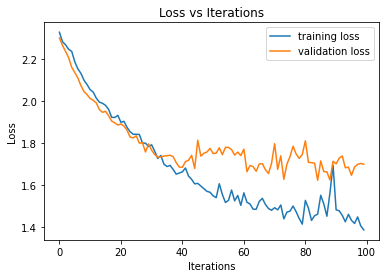

In [11]:
#plotting of graphs
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="validation loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.show()

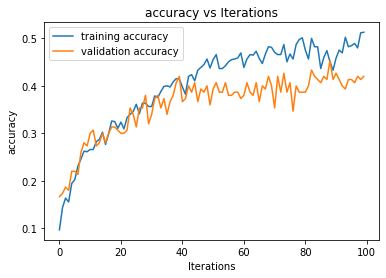

In [12]:
plt.plot(history.history['accuracy'],label="training accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.xlabel("Iterations")
plt.ylabel("accuracy")
plt.title("accuracy vs Iterations")
plt.legend()
plt.show()

In [33]:
model = model_building_1()
opt = optimizer.Adam(lr=1e-4,decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
print('------------------------------Model Compilation Done------------------------------------\n')
# print(model.summary())

------------------------------Model Compilation Done------------------------------------



In [29]:
print('------------------------------Model Training Started------------------------------------\n')
history = model.fit(X_train,y_train,epochs=30,batch_size=8,validation_data=(X_test,y_test))

------------------------------Model Training Started------------------------------------

Train on 850 samples, validate on 150 samples
Epoch 1/30
850/850 [==============================] - 29s 34ms/sample - loss: 2.7311 - accuracy: 0.1106 - val_loss: 2.2692 - val_accuracy: 0.1600
Epoch 2/30
850/850 [==============================] - 14s 16ms/sample - loss: 2.5737 - accuracy: 0.1459 - val_loss: 2.2659 - val_accuracy: 0.1800
Epoch 3/30
850/850 [==============================] - 14s 16ms/sample - loss: 2.3861 - accuracy: 0.1918 - val_loss: 2.2840 - val_accuracy: 0.1933
Epoch 4/30
850/850 [==============================] - 14s 16ms/sample - loss: 2.3200 - accuracy: 0.2012 - val_loss: 2.2701 - val_accuracy: 0.2533
Epoch 5/30
850/850 [==============================] - 14s 16ms/sample - loss: 2.2805 - accuracy: 0.2059 - val_loss: 2.2283 - val_accuracy: 0.2733
Epoch 6/30
850/850 [==============================] - 13s 16ms/sample - loss: 2.2472 - accuracy: 0.2365 - val_loss: 2.2010 - val_accur

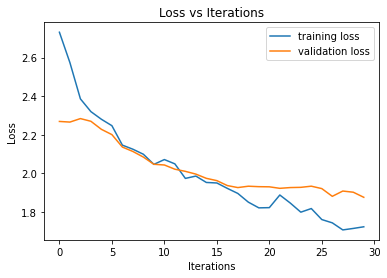

In [30]:
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="validation loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.show()

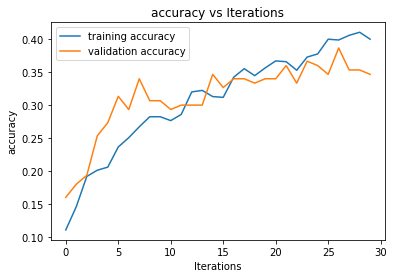

In [31]:
plt.plot(history.history['accuracy'],label="training accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.xlabel("Iterations")
plt.ylabel("accuracy")
plt.title("accuracy vs Iterations")
plt.legend()
plt.show()